In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv(r'F:\minowa\BloodPressureEstimation\data\results\ppg_features_pulsedb_train_min180.csv',index_col=0  )
test_df = pd.read_csv(r'F:\minowa\BloodPressureEstimation\data\results\ppg_features_pulsedb_test_min180.csv',index_col=0  )
train_df.shape, test_df.shape

((701639, 102), (87507, 102))

In [4]:
train_df.columns

Index(['Tc', 'Ts', 'Td', 'Tsteepest', 'Steepest', 'TNegSteepest',
       'NegSteepest', 'TdiaRise', 'DiaRise', 'SteepDiaRise',
       ...
       'T_peak_e_norm', 'AI', 'bd', 'bcda', 'sdoo', 'cycle_zero',
       'signal_index', 'sbp', 'subject', 'dbp'],
      dtype='object', length=102)

In [3]:

def add_sbp_class(df, col_name='sbp', new_col='sbp_class'):
    """
    SBP値に応じてクラスを付与する関数
      - sbp < 100 → 0
      - 100 <= sbp < 140 → 1
      - sbp >= 140 → 2

    Parameters
    ----------
    df : pd.DataFrame
        SBP列を含むデータフレーム
    col_name : str, default 'sbp'
        SBPの列名
    new_col : str, default 'sbp_class'
        新しい列名

    Returns
    -------
    df : pd.DataFrame
        新しい列が追加されたDataFrame
    """
    conditions = [
        df[col_name] < 100,
        (df[col_name] >= 100) & (df[col_name] < 140),
        df[col_name] >= 140
    ]
    values = [0, 1, 2]
    df[new_col] = np.select(conditions, values).astype('int')
    return df

In [4]:
train_df = add_sbp_class(train_df)
test_df = add_sbp_class(test_df)
train_df.shape,test_df.shape

((701639, 103), (87507, 103))

In [11]:
train_X = train_df[train_df['sbp_class'] != 1]
train_Y = train_X['sbp_class'] // 2 
train_X = train_X.drop(['signal_index', 'sbp', 'subject', 'dbp','sbp_class'],axis=1)
test_X = test_df[test_df['sbp_class'] != 1]
test_Y = test_X['sbp_class'] // 2 
test_X = test_X.drop(['signal_index', 'sbp', 'subject', 'dbp','sbp_class'],axis=1)
train_X.shape, train_Y.shape

((238773, 98), (238773,))

In [12]:
train_df = add_sbp_class(train_df)
test_df = add_sbp_class(test_df)
train_Y = train_df['sbp_class']
train_X = train_df.drop(['signal_index', 'sbp', 'subject', 'dbp','sbp_class'],axis=1)
test_Y = test_df['sbp_class']
test_X = test_df.drop(['signal_index', 'sbp', 'subject', 'dbp','sbp_class'],axis=1)
train_X.shape, train_Y.shape

((701639, 98), (701639,))

In [6]:
train_X.shape, train_Y.shape

((238773, 98), (238773,))

In [23]:
train_Y

3         1
11        1
13        1
23        1
32        1
         ..
730613    0
730616    0
730617    0
730623    0
730624    0
Name: sbp_class, Length: 238773, dtype: int32

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [14]:
test_Y.nunique()

3

In [16]:
from sklearn.utils.class_weight import compute_sample_weight

    

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	train's multi_error: 0.466649	test's multi_error: 0.54863

Top 10 important features:
          feature    importance
48        S2_norm  89381.389648
23      DW25_norm  67750.545731
10  TSystoDiaRise  52511.658234
47        S1_norm  43795.493378
74            T_b  31709.352173
59          apg_e  20181.784790
81       T_d_norm  17008.779236
35      SW75_norm  12413.849854
89  T_peak_b_norm  11927.891846
78       T_a_norm   9377.457031


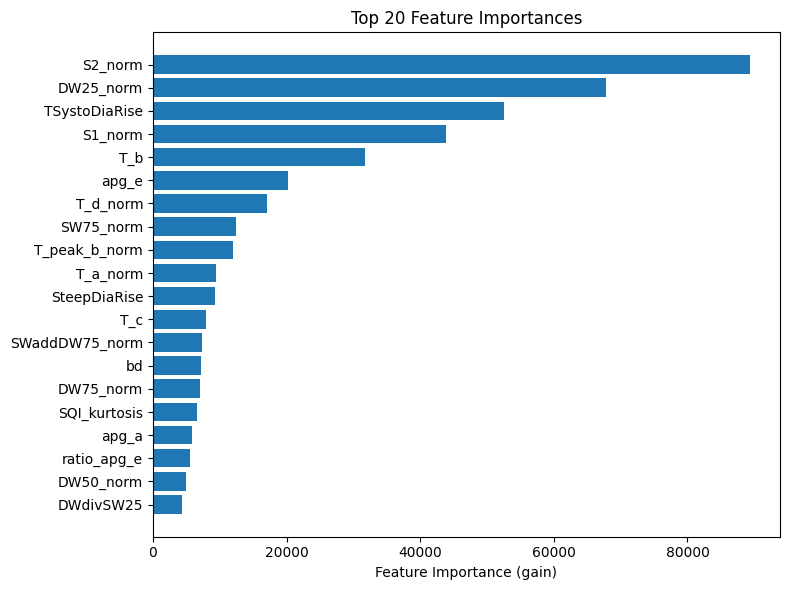

Accuracy: 0.4514
Confusion Matrix:
[[ 8205  4023  2488]
 [16870 22743 18855]
 [ 1936  3837  8550]]

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.56      0.39     14716
           1       0.74      0.39      0.51     58468
           2       0.29      0.60      0.39     14323

    accuracy                           0.45     87507
   macro avg       0.44      0.51      0.43     87507
weighted avg       0.59      0.45      0.47     87507



In [18]:
# train lightgbm
# --- LightGBM データセットに変換 ---
weights = compute_sample_weight(class_weight='balanced', y=train_Y)
lgb_train = lgb.Dataset(train_X, label=train_Y, weight=weights)
lgb_test = lgb.Dataset(test_X, label=test_Y, reference=lgb_train)
# --- ハイパーパラメータ設定 ---
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1,
    'random_state': 42,
}
if  test_Y.nunique() > 2:
    params['objective'] = 'multiclass'
    params['metric'] = 'multi_error'
    params['num_class'] = test_Y.nunique()
# --- モデル学習 ---
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    valid_names=['train', 'test'],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

# --- 予測 ---
y_pred_prob = model.predict(test_X, num_iteration=model.best_iteration)
y_pred = np.argmax(y_pred_prob, axis=1) if test_Y.nunique() > 2 else (y_pred_prob >= 0.5).astype(int)

# --- 評価 ---
acc = accuracy_score(test_Y, y_pred)
cm = confusion_matrix(test_Y, y_pred)

# --- Feature Importance ---
importance_df = pd.DataFrame({
    'feature': train_X.columns,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values(by='importance', ascending=False)

print("\nTop 10 important features:")
print(importance_df.head(10))

# --- 可視化 ---
plt.figure(figsize=(8, 6))
plt.barh(importance_df['feature'][:20][::-1], importance_df['importance'][:20][::-1])
plt.xlabel("Feature Importance (gain)")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()
print(f"Accuracy: {acc:.4f}")
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(test_Y, y_pred))

## 回帰

### sbp

In [4]:
from sklearn.preprocessing import StandardScaler
train_Y = train_df['sbp']
train_X = train_df.drop(['signal_index', 'sbp', 'subject', 'dbp','sbp_class','sbp_bin'],axis=1,errors='ignore')
test_Y = test_df['sbp']
test_X = test_df.drop(['signal_index', 'sbp', 'subject', 'dbp','sbp_class','sbp_bin'],axis=1,errors='ignore')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_X)
X_test_scaled = scaler.transform(test_X)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(train_Y.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(test_Y.values.reshape(-1, 1)).ravel()
model = lgb.LGBMRegressor(random_state=42,n_estimators=2000,verbose=-1)
model.fit(X_train_scaled, y_train_scaled,   callbacks=[lgb.early_stopping(stopping_rounds=50),lgb.log_evaluation(period=100)],eval_set=[(X_test_scaled, y_test_scaled)],
          eval_metric="mae")
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
mse = mean_squared_error(test_Y, y_pred)
mae = mean_absolute_error(test_Y, y_pred)   
me = (test_Y - y_pred).mean()
std = (test_Y - y_pred).std()

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, ME: {me:.4f}, STD: {std:.4f}")

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 0.681564	valid_0's l2: 0.738439
[200]	valid_0's l1: 0.679951	valid_0's l2: 0.737374
Early stopping, best iteration is:
[181]	valid_0's l1: 0.679596	valid_0's l2: 0.736048
MSE: 321.4203, MAE: 14.2015, ME: 0.5893, STD: 17.9186


In [5]:
test_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\test_features.parquet' ).drop('Unnamed: 0', axis=1, errors='ignore')  
test_Y = test_df['sbp']
test_X = test_df.drop(['signal_index', 'sbp', 'subject', 'dbp','sbp_class','sbp_bin'],axis=1, errors='ignore')
X_test_scaled = scaler.transform(test_X)
y_test_scaled = scaler_y.transform(test_Y.values.reshape(-1, 1)).ravel()
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
mse = mean_squared_error(test_Y, y_pred)
mae = mean_absolute_error(test_Y, y_pred)   
me = (test_Y - y_pred).mean()
std = (test_Y - y_pred).std()

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, ME: {me:.4f}, STD: {std:.4f}")

MSE: 455.3211, MAE: 17.2108, ME: 3.2172, STD: 21.0946


### dbp

In [8]:
train_Y = train_df['dbp']
test_Y = test_df['dbp']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_X)
X_test_scaled = scaler.transform(test_X)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(train_Y.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(test_Y.values.reshape(-1, 1)).ravel()
model = lgb.LGBMRegressor(random_state=42,n_estimators=2000,verbose=-1)
model.fit(X_train_scaled, y_train_scaled,   callbacks=[lgb.early_stopping(stopping_rounds=50),lgb.log_evaluation(period=100)],eval_set=[(X_test_scaled, y_test_scaled)],
          eval_metric="mae")
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
mse = mean_squared_error(test_Y, y_pred)
mae = mean_absolute_error(test_Y, y_pred)   
me = (test_Y - y_pred).mean()
std = (test_Y - y_pred).std()

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, ME: {me:.4f}, STD: {std:.4f}")

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 0.677004	valid_0's l2: 0.745513
Early stopping, best iteration is:
[129]	valid_0's l1: 0.676203	valid_0's l2: 0.743233
MSE: 118.1949, MAE: 8.5274, ME: 0.3870, STD: 10.8649


In [10]:
test_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\test_features.parquet' ).drop('Unnamed: 0', axis=1, errors='ignore')  
test_Y = test_df['dbp']
test_X = test_df.drop(['signal_index', 'sbp', 'subject', 'dbp','sbp_class','sbp_bin'],axis=1, errors='ignore')
X_test_scaled = scaler.transform(test_X)
y_test_scaled = scaler_y.transform(test_Y.values.reshape(-1, 1)).ravel()
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
mse = mean_squared_error(test_Y, y_pred)
mae = mean_absolute_error(test_Y, y_pred)   
me = (test_Y - y_pred).mean()
std = (test_Y - y_pred).std()

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, ME: {me:.4f}, STD: {std:.4f}")

MSE: 145.4288, MAE: 9.4774, ME: 1.4343, STD: 11.9739
